In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from utils import *

In [2]:
PATH_TRAIN = "../processed_data/cleaned_data/clean_data.csv"
PATH_TEST = "../processed_data/cleaned_data/clean_test_data.csv"

train_df = pd.read_csv(PATH_TRAIN)
test_df = pd.read_csv(PATH_TEST)

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (13056, 91)
Test data shape: (3091, 91)


In [3]:
X_train = train_df.drop(["Participant_ID", "Depression"], axis=1)
y_train = train_df[["Participant_ID", "Depression", "Gender"]]

X_test = test_df.drop(["Participant_ID", "Depression"], axis=1)
y_test = test_df[["Participant_ID", "Depression", "Gender"]]

In [4]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [5]:
model = RandomForestClassifier(max_depth=100, random_state=42, n_estimators=50, 
                               class_weight=calculate_class_weights(y_train, "Depression"))
model.fit(X_train_scaled,y_train["Depression"])
predicted = model.predict(X_test)
y_test["Depression_predicted"] = predicted

/Users/vikram/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/var/folders/6m/wg76ryq57fnb356nt5xwlbl80000gn/T/ipykernel_47032/411549496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["Depression_predicted"] = predicted


Accuracy: 0.7
Balanced Accuracy: 0.5
Equality of Opportunity: 1.0


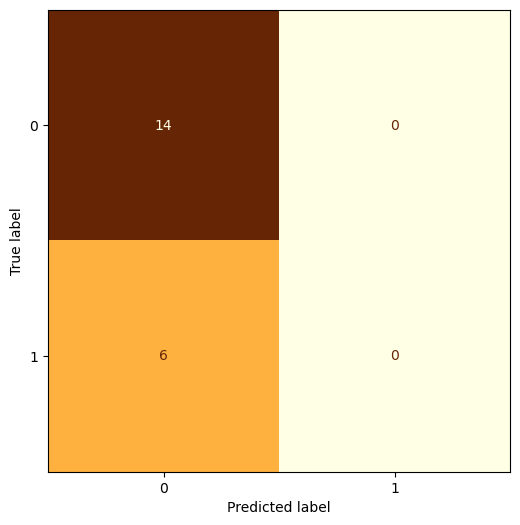

In [6]:
acc, bal_acc, eo_score = compute_metrics(y_test, eo=True)

print(f"Accuracy: {acc}")
print(f"Balanced Accuracy: {bal_acc}")
print(f"Equality of Opportunity: {eo_score}")

show_conf_matrix(y_test)

## Imblearn's Balanced Random Forests

In [7]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [8]:
model = BalancedRandomForestClassifier(max_depth=500, random_state=42, n_estimators=500)
                               #class_weight=calculate_class_weights(y_train, "Depression"))
model.fit(X_train_scaled,y_train["Depression"])
predicted = model.predict(X_test_scaled)
y_test["Depression_predicted"] = predicted

/Users/vikram/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vikram/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/var/folders/6m/wg76ryq57fnb356nt5xwlbl80000gn/T/ipykernel_47032/3937183986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Accuracy: 0.6
Balanced Accuracy: 0.5714285714285714
Equality of Opportunity: 0.4


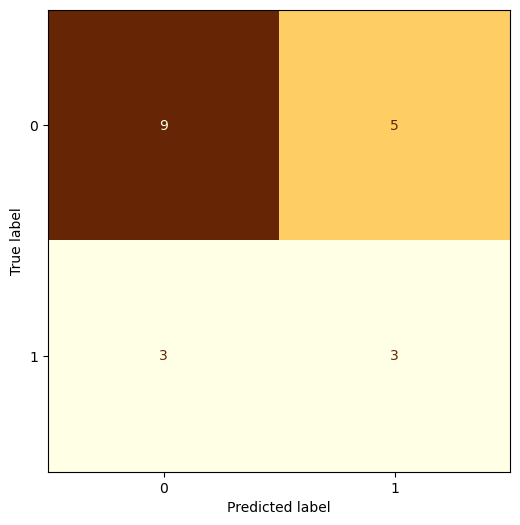

In [9]:
acc, bal_acc, eo_score = compute_metrics(y_test, eo=True)

print(f"Accuracy: {acc}")
print(f"Balanced Accuracy: {bal_acc}")
print(f"Equality of Opportunity: {eo_score}")

show_conf_matrix(y_test, model_name= "Balanced Random Forests")

In [10]:
n_best_features = pd.DataFrame({'columns': X_train.columns, 'importance': model.feature_importances_})
n_best_features.head()

,columns,importance
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.022002
1,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,0.009770
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.021165
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.024008
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.023155


In [11]:
n_best_features = n_best_features.sort_values(by='importance', ascending=False)
n_best_features.head()

,columns,importance
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.024008
87,equivalentSoundLevel_dBp,0.023825
10,loudness_sma3_amean,0.023752
14,loudness_sma3_percentile80.0,0.023444
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.023155


In [12]:
import warnings
warnings.filterwarnings("ignore")

n_values = list(range(10, 91, 10))
eo_scores = []
acc_scores = []
bal_acc_scores = []

for n in n_values:
    features = list(n_best_features.iloc[:n, 0].values)
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    sc = StandardScaler()
    X_train_subset_scaled = sc.fit_transform(X_train_subset)
    X_test_subset_scaled = sc.transform(X_test_subset)
    model = BalancedRandomForestClassifier(max_depth=200, random_state=42, n_estimators=300)
    model.fit(X_train_subset_scaled,y_train["Depression"])
    predicted = model.predict(X_test_subset_scaled)
    y_test["Depression_predicted"] = predicted

    acc, bal_acc, eo_score = compute_metrics(y_test, eo=True)

    eo_scores.append(eo_score)
    acc_scores.append(acc)
    bal_acc_scores.append(bal_acc)

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
# ax = ax.flatten()

# ax[0].plot(n_values, eo_scores , 'o-')
# ax[0].set_xlabel("Number of features")
# ax[0].set_ylabel("EO score")
# ax[0].grid()

# ax[1].plot(n_values, acc_scores , 'o-')
# ax[1].set_xlabel("Number of features")
# ax[1].set_ylabel("Accuracy")
# ax[1].grid()

# ax[2].plot(n_values, bal_acc_scores, 'o-')
# ax[2].set_xlabel("Number of features")
# ax[2].set_ylabel("Balanced Accuracy")
# ax[2].grid()

# plt.show()

[]

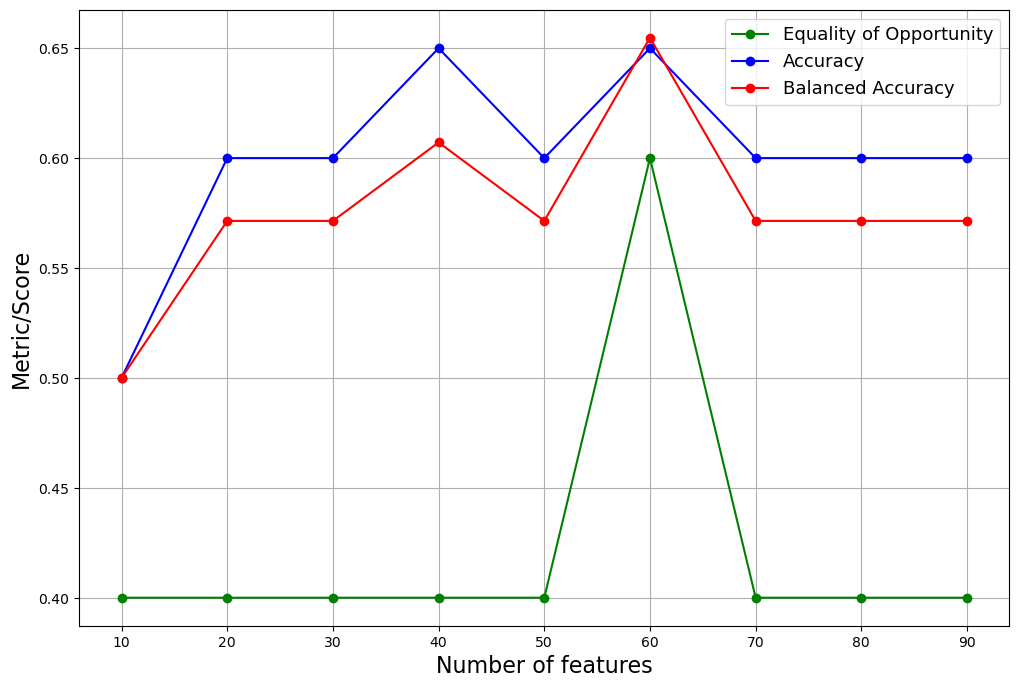

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(n_values, eo_scores , 'go-', label="Equality of Opportunity")
plt.plot(n_values, acc_scores , 'bo-',  label="Accuracy")
plt.plot(n_values, bal_acc_scores , 'ro-',  label="Balanced Accuracy")
plt.xlabel("Number of features", fontsize = 16)
plt.ylabel("Metric/Score", fontsize = 16)
plt.legend(fontsize = 13)
plt.grid()
plt.plot()